In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from enviroments import env_red, P_j_dist, P_j
from itertools import product


In [8]:
# Max time for departure
T = 50 #Max time
time = np.arange(1, T) #TIme index

#Set of products
J = 5 #Num of products
r_j = [100,200,300,400,500] #Price for products

#Set of resoruces
I = 1 #Soruce/Fly legs
c_i = np.array([50]) #Capacity for fly leg

#Customer segment
L = 1 #Types of customer
p_l = np.array([1]) #Probabilidad de pertenecer a un segmento
lambd = 0.3 #PRobabilidad de llegada de un cliente
lambd_l = lambd*p_l

#Adjacency matrix Fligt products
A_ij = np.array([
    [1, 1, 1, 1, 1]
])

with open('results/p_j.pickle', 'rb') as archivo:
    p_j = np.flip(pickle.load(archivo))
        
    #Weigjt of MNL
v_lj = np.array([
    np.insert(p_j, 0, 0)
])

#Modelo exponencial: "Exp"
#Modelo MNL: "MNL"
demand_model = "MNL" 
env = env_red(L,v_lj,r_j,c_i,T,I,A_ij,J,p_l,lambd,demand_model)



1.0


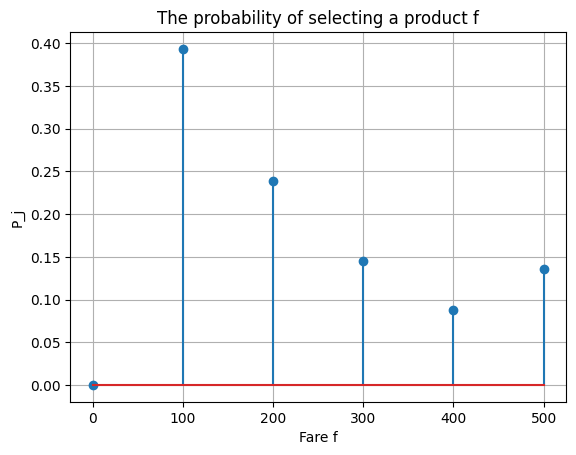

In [17]:
S = np.array([1,1,1,1,1])

dist = P_j_dist(S,L,v_lj,p_l,1,demand_model)
print(sum(dist))

f = np.array([0,100,200,300,400,500])

plt.stem(f, dist)
plt.xlabel('Fare f')
plt.ylabel('P_j')
plt.title('The probability of selecting a product f')
plt.grid(True)
plt.show()

In [23]:
#Expected revenue dada una acción a
def R(a,L,v_lj,r_j,p_l):
    list = []
    for j, a_j in enumerate(a):
        if a_j == 1:
            list.append(P_j(a,L,j,v_lj,p_l,demand_model)*r_j[j])
    return sum(list)

#Probabilidad de que se produzca una reserva dada una acción a
def P(a,L,v_lj,p_l):
    list = []
    for j, a_j in enumerate(a):
        if a_j == 1:
            list.append(P_j(a,L,j,v_lj,p_l,demand_model))
    return sum(list)

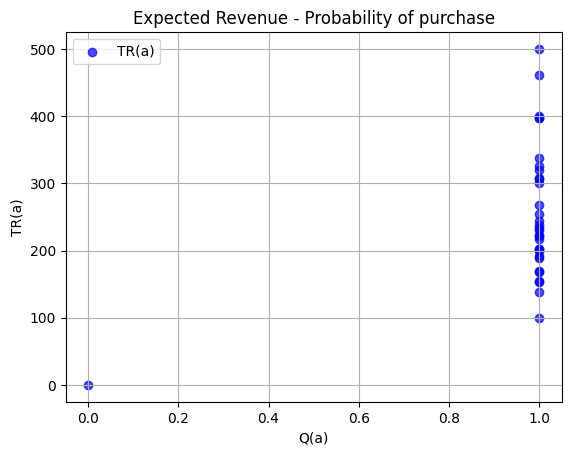

In [24]:

Q_vec = []
TR_vec = []
for s in list(product([0,1], repeat=J)):
    TR_vec.append(R(s,L,v_lj,r_j,p_l))
    Q_vec.append(P(s,L,v_lj,p_l))
    dist = P_j_dist(s,L,v_lj,p_l,lambd,demand_model)
    if dist[0] < 0:
        print("bug")
    
plt.scatter(Q_vec, TR_vec,label= "TR(a)", color='blue', alpha=0.7)  # Crear la nube de puntos
plt.title('Expected Revenue - Probability of purchase')
plt.xlabel('Q(a)')
plt.ylabel('TR(a)')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
from itertools import product
C = c_i[0]
seats = np.arange(0, C + 1)
time = np.arange(0, T)

states_map = {}
for idx, (x, t) in enumerate(product(seats, time)):
    states_map[(x, t)] = idx

In [26]:
m = len(f)

action_space = list(product([0,1], repeat=J))

nS = (C+1)*T
nA = len(action_space)

lambd = 0.3

P_sa_s = np.zeros((nS, nA, nS))
R_sa_s = np.zeros((nS,nA,nS))


for idx, (x, t) in enumerate(product(seats, time)):
    if t != (T-1) and x != C:
        idx_1 = states_map[(x + 1, t + 1)]
        idx_2 = states_map[(x, t + 1)]

        for a_idx, a in enumerate(action_space):
            dist =  P_j_dist(a,L,v_lj,p_l,lambd,demand_model)
            P_sa_s[idx, a_idx, idx_1] = 1 - dist[0]
            P_sa_s[idx, a_idx, idx_2] = dist[0]
            R_sa_s[idx, a_idx,idx_1] = lambd*R(a,L,v_lj,r_j,p_l)
                

In [27]:
R_sa = np.zeros((nS,nA))

for idx, (x, t) in enumerate(product(seats,time)):
    if t != (T-1) and x != C:
        for a_idx, a in enumerate(action_space):
            R_sa[idx, a_idx] = lambd*R(a,L,v_lj,r_j,p_l)
            idx_1 = states_map[(x + 1, t + 1)]
            R_sa_s[idx, a_idx,idx_1] = R(a,L,v_lj,r_j,p_l)


            

VALUE ITERATION

In [28]:
V_old = np.zeros(nS)
error_value = []
gamma = 1
for _ in range(60):
    V = np.max(R_sa + gamma * P_sa_s @ V_old, axis=1)
    assert np.all(V >= V_old)
    error_value.append(np.linalg.norm(V - V_old))
    V_old = V
V_value = V

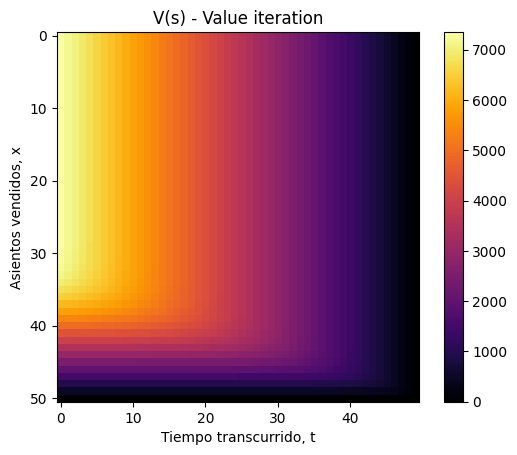

In [29]:
# Crear una matriz de ejemplo
matriz = np.zeros((C+1,T))
for idx, (x, t) in enumerate(product(seats, time)):  # Cambia el tamaño de la matriz según sea necesario
    matriz[x,t] = V_value[idx]

plt.imshow(matriz, cmap='inferno', interpolation='nearest')
plt.colorbar()  # Agregar barra de colores para referencia
plt.title('V(s) - Value iteration')
plt.xlabel('Tiempo transcurrido, t')
plt.ylabel('Asientos vendidos, x')
plt.show()


POLICY ITERATION

In [30]:

def policy_evaluation(Pi):
    P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi)
    R_s = np.einsum('ij, ij -> i', R_sa, Pi)
    
    V = np.zeros(nS)
    for _ in range(100):
        V = R_s + gamma * P_s_s @ V
        
    Q = R_sa + gamma * P_sa_s @ V
    return V, Q

def policy_improvement(Q):
    Pi = np.zeros((nS, nA))
    for s in range(nS):
        a = np.argmax(Q[s, :])
        Pi[s, a] = 1
    return Pi

V_old = np.zeros(nS)
Q_old = np.zeros((nS, nA))
Pi = np.random.rand(nS, nA)
Pi /= Pi.sum(axis=1, keepdims=True)
error_plicy = []
for _ in range(30):
    V, Q = policy_evaluation(Pi)
    Pi = policy_improvement(Q)

    #print(V)
    #assert np.all(V >= V_old)
    #assert np.all(Q >= Q_old)
    
    error_plicy.append(np.linalg.norm(V - V_old))
    V_old = V
    Q_old = Q

V_policy = V

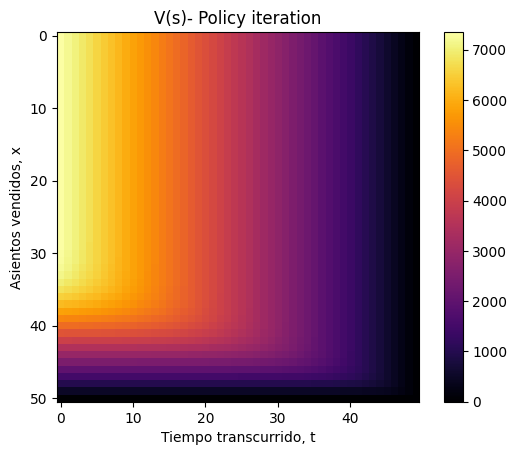

In [31]:
# Crear una matriz de ejemplo
matriz = np.zeros((C+1,T))
for idx, (x, t) in enumerate(product(seats, time)):  # Cambia el tamaño de la matriz según sea necesario
    matriz[x,t] = V_policy[idx]

plt.imshow(matriz, cmap='inferno', interpolation='nearest')
plt.colorbar()  # Agregar barra de colores para referencia
plt.title('V(s)- Policy iteration')
plt.xlabel('Tiempo transcurrido, t')
plt.ylabel('Asientos vendidos, x')
plt.show()

In [32]:
V_policy_p = np.max(R_sa + gamma * P_sa_s @ V_policy, axis=1)
np.linalg.norm(V_policy_p - V_policy)

0.0

In [33]:
Pi = np.zeros((nS, nA))
Q =  R_sa + gamma * P_sa_s @ V

for s in range(nS):
    a = np.argmax(Q[s, :])
    Pi[s, a] = 1

P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi)
R_s = np.einsum('ij, ij -> i', R_sa, Pi)

V_value_p = R_s + gamma * P_s_s @ V_value
print(np.linalg.norm(V_value_p -V_value))

0.0


SOLUCIÓN CLASICA

In [42]:
vec_Q = np.array(Q_vec)

def opt_policy(V):
    Pi = np.zeros((nS, nA))
    for idx, (x, t) in enumerate(product(seats,time)):
        if t != (T-1) and x != C:
            BP = V[states_map[x,t+1]] - V[states_map[x+1,t+1]]
            a = np.argmax(R_sa[states_map[x,t],:]-lambd*BP*vec_Q)
            Pi[idx, a] = 1
    return Pi



V = np.zeros(nS)
Pi = opt_policy(V)

P_s_s = np.einsum('ijk, ij -> ik', P_sa_s, Pi)
R_s = np.einsum('ij, ij -> i', R_sa, Pi)
    
error_clasic = []

for _ in range(30):
    V, Q = policy_evaluation(Pi)
    Pi = opt_policy(V)

    #print(V)
    #assert np.all(V >= V_old)
    #assert np.all(Q >= Q_old)
    
    error_clasic.append(np.linalg.norm(V - V_old))
    V_old = V
    Q_old = Q
V_clasic = V
        

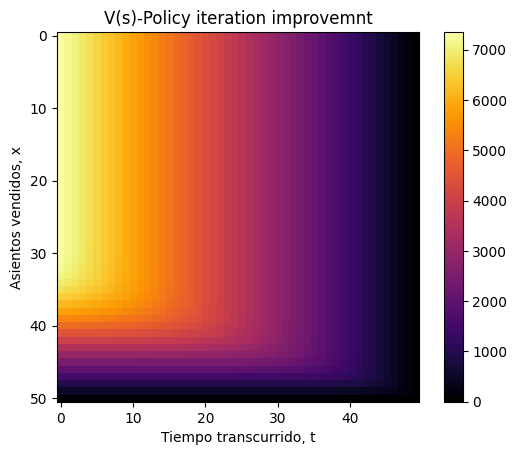

In [43]:
matriz = np.zeros((C+1,T))
for idx, (x, t) in enumerate(product(seats, time)):  # Cambia el tamaño de la matriz según sea necesario
    matriz[x,t] = V_clasic[idx]

plt.imshow(matriz, cmap='inferno', interpolation='nearest')
plt.colorbar()  # Agregar barra de colores para referencia
plt.title('V(s)-Policy iteration improvemnt')
plt.xlabel('Tiempo transcurrido, t')
plt.ylabel('Asientos vendidos, x')
plt.show()

In [44]:
np.linalg.norm(V_clasic-V_value)

0.0

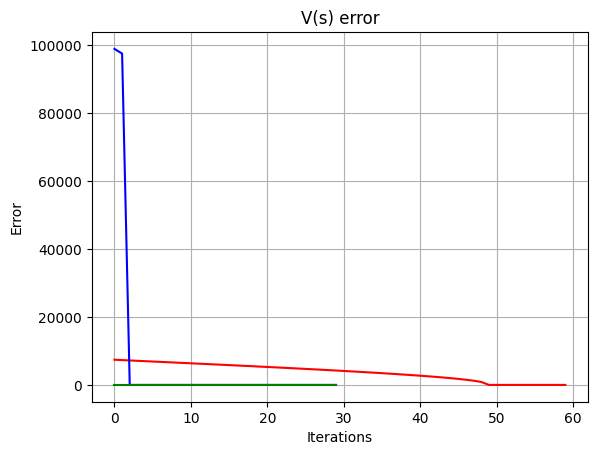

In [45]:
r = 0
plt.plot(range(r,len(error_value)), error_value[r:], color='red')
plt.plot(range(r,len(error_plicy)), error_plicy[r:], color='blue')
plt.plot(range(r,len(error_clasic)), error_clasic[r:], color='green')
plt.title('V(s) error')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.grid(True)
plt.show()

In [38]:
V = np.zeros(nS)
Q_vec = np.array(vec_Q)

for idx, (t, x) in enumerate(product(time[::-1],seats[::-1])):
    if t != (T-1) and x != C:
        BP = V[states_map[x,t+1]] - V[states_map[x+1,t+1]]
        a = np.argmax(R_sa[states_map[x,t],:]-lambd*BP*Q_vec)
        V[states_map[x,t]] = V[states_map[x,t+1]] + R_sa[states_map[x,t],a] - lambd*BP*Q_vec[a]


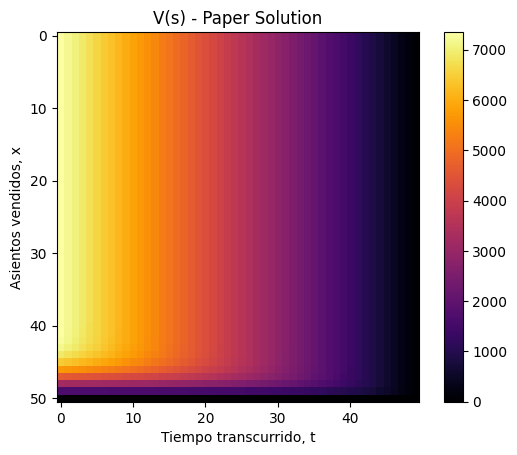

In [39]:
matriz = np.zeros((C+1,T))
for idx, (s, t) in enumerate(product(seats, time)):  # Cambia el tamaño de la matriz según sea necesario
    matriz[s,t] = V[idx]

plt.imshow(matriz, cmap='inferno', interpolation='nearest')
plt.colorbar()  # Agregar barra de colores para referencia
plt.title('V(s) - Paper Solution')
plt.xlabel('Tiempo transcurrido, t')
plt.ylabel('Asientos vendidos, x')
plt.show()

In [40]:
print(np.linalg.norm(V_value -  V_policy))
print(np.linalg.norm(V_policy - V_clasic))
print(np.linalg.norm(V_policy - V))

0.0
0.0
36115.730527624604
